In [100]:
import pandas as pd
import numpy as np
import cv2
import os
import operator
from tqdm import tqdm
import random
import os, re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from glob import glob 
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon

print('OpenCV Version:',cv2.__version__)

OpenCV Version: 3.4.3


In [101]:
def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
            
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    try:
        for polygon in polygons:
            # An polygon has either shape (n,2), 
            # either (n,1,2) if it is a cv2 contour (like convex hull).
            # In the latter case, reshape in (n,2)
            if len(polygon.shape)==3:
                polygon=polygon.reshape(-1,2)
            patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
            ax.add_patch(patch)
    except:
        print(img)

In [102]:
class Backgrounds(object):
    #def __init__(self):
    def load(self, file):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Number of background images loaded :", self._nb_images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg

In [103]:
class Cards(object):
    #def __init__(self):
    def load_dict(self, dictionary):
        self._cards=dictionary
        # self._cards is a dictionary where keys are card names and values are lists of (img,hullHL,hullLR) 
        self._nb_cards_by_value={k:len(self._cards[k]) for k in self._cards}
        print("Number of cards loaded per name :", self._nb_cards_by_value)

    def get_random(self, card_name=None, display=False):
        if card_name is None:
            card_name= random.choice(list(self._cards.keys()))
        card,hull1,hull2=self._cards[card_name]#
        [random.randint(0,self._nb_cards_by_value[card_name]-1)]
        print(card_name)
        if display:
            if display: display_img(card,[hull1,hull2],"rgb")
        return card,card_name,hull1,hull2

In [104]:
def varianceOfLaplacian(img):
    """
    Compute the Laplacian of the image and then return the focus
    measure, which is simply the variance of the Laplacian
    Source: A.Rosebrock, https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    """
    return cv2.Laplacian(img, cv2.CV_64F).var()

In [105]:
def extract_card (img, output_fn=None, min_focus=120, debug=False):
    """
    """
    
    imgwarp=None
    
    # Check the image is not too blurry
    focus=varianceOfLaplacian(img)
    if focus < min_focus: 
        if debug: print("Focus too low :", focus)
        return False,None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bilateral=cv2.bilateralFilter(gray,11,17,17)
    medBlur = cv2.medianBlur(bilateral,5)

    ret,thresh = cv2.threshold(medBlur,130,255,cv2.THRESH_BINARY)
    #th3 = cv2.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
    edge=cv2.Canny(thresh,30,200)

    # find contours in the edged image, keep only the largest
    # ones, and initialize our screen contour
    _,contours, hierarchy = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key = cv2.contourArea, reverse = True)
  
    contidict={}   
    validict={}
    boxDict={}
    rectDict={}
    # loop over our contours save values into a dict to retrieve the maximum
    for c in range(0,len(cnts)):
        rect=cv2.minAreaRect(cnts[c])
        rectDict[c]=rect
        box=cv2.boxPoints(rect)
        box=np.int0(box)
        boxDict[c]=box
        areaCnt=cv2.contourArea(cnts[c])
        areaBox=cv2.contourArea(box)
        contidict[c]=areaBox
        try:
            valid=areaCnt/areaBox>0.95
            validict[c]=valid
        except:
            validict[c]=False


    #print(valid,':',areaCnt/areaBox)     
    maxarea=max(contidict.items(), key=operator.itemgetter(1))[0]
        
    if validict[maxarea]:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar)=rectDict[maxarea]
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr>hr:
            Mp=cv2.getPerspectiveTransform(np.float32(boxDict[maxarea]),refCard)
        else:
            Mp=cv2.getPerspectiveTransform(np.float32(boxDict[maxarea]),refCardRot)
        # Determine the warped image by applying the transformation to the image
        imgwarp=cv2.warpPerspective(img,Mp,(cardW,cardH))
        # Add alpha layer
        imgwarp=cv2.cvtColor(imgwarp,cv2.COLOR_BGR2BGRA)

        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta=cnts[maxarea].reshape(1,-1,2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp=cv2.perspectiveTransform(cnta,Mp)
        cntwarp=cntwarp.astype(np.int)

        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel=np.zeros(imgwarp.shape[:2],dtype=np.uint8)
        # Then fill in the contour to make opaque this zone of the card 
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)

        # Apply the alphamask onto the alpha channel to clean it
        alphachannel=cv2.bitwise_and(alphachannel,alphamask)

        # Add the alphachannel to the warped image
        imgwarp[:,:,3]=alphachannel

        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn,imgwarp)

    if debug:
        #cv2.imshow("Gray",gray)
        plt.imshow(gray)
        #cv2.imshow("Canny",edge)
        plt.imshow(edge)
        edge_bgr=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
        cv2.drawContours(edge_bgr,[boxDict[maxarea]],0,(0,0,255),3)
        cv2.drawContours(edge_bgr,[cnts[maxarea]],0,(0,255,0),-1)
        #cv2.imshow("Contour with biggest area",edge_bgr)
        plt.imshow(edge_bgr)
        
        if validict[maxarea]:
            #cv2.imshow("Alphachannel",alphachannel)
            plt.imshow(alphachannel, dtype = np.uint8)
            #cv2.imshow("Extracted card",imgwarp)
            plt.imshow(imgwarp)

    return valid,imgwarp

In [106]:
def findHull(img, corner, debug="no", hmin=.01, hmax=1):
    """
        Find in the zone 'corner' of image 'img' and return, the convex hull delimiting
        the value and suit symbols
        'corner' (shape (4,2)) is an array of 4 points delimiting a rectangular zone, 
        takes one of the 2 possible values : refCornerHL or refCornerLR
        debug=
    """
    #img=(img.copy(), cv2.COLOR_BGR2GRAY)
    kernel = np.ones((3,3),np.uint8)
    corner=corner.astype(np.int)

    # We will focus on the zone of 'img' delimited by 'corner'
    x1=int(corner[0][0])
    y1=int(corner[0][1])
    x2=int(corner[2][0])
    y2=int(corner[2][1])
    w=x2-x1
    h=y2-y1
    zone=img[y1:y2,x1:x2].copy()
    
    strange_cnt=np.zeros_like(zone)
    gray=cv2.cvtColor(zone,cv2.COLOR_BGR2GRAY)
    bilateral=cv2.bilateralFilter(gray,20,10,100)#<---added
    ret,thresh=cv2.threshold(bilateral,157,220,cv2.THRESH_TOZERO)#<----added
    thld=cv2.Canny(thresh,30,200)
    #thld=cv2.Canny(thresh,1,200)
    thld = cv2.dilate(thld,kernel,iterations=1)
    if debug!="no": plt.imshow(thld)
    
    # Find the contours
    _,contours,_=cv2.findContours(thld.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    min_area=75 # We will reject contours with small area. TWEAK, 'zoom' dependant
    min_solidity=0.2 # Reject contours with a low solidity. TWEAK
    
    concat_contour=None # We will aggregate in 'concat_contour' the contours that we want to keep
    
    ok=True
    for c in contours:
        area=cv2.contourArea(c)

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        #print(hull_area)
        solidity = float(area)/hull_area#<----
        # Determine the center of gravity (cx,cy) of the contour
        M=cv2.moments(c)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        #  abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 : TWEAK, the idea here is to keep only the contours which are closed to the center of the zone
        if area >= min_area and abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 and solidity>min_solidity:
            if debug != "no" :
                cv2.drawContours(zone,[c],0,(255,0,0),-1)
            if concat_contour is None:
                concat_contour=c
            else:
                concat_contour=np.concatenate((concat_contour,c))
        if debug != "no" and solidity <= min_solidity :
            print("Solidity",solidity)
            cv2.drawContours(strange_cnt,[c],0,255,2)
            plt.imshow(strange_cnt)
            
    if concat_contour is not None:  
        # We can now determine the hull
        hull=cv2.convexHull(concat_contour)
        hull_area=cv2.contourArea(hull)
        # If the area of the hull is to small or too big, there may be a problem
        print(hull_area)
        min_hull_area=hull_area*hmin # TWEAK, deck and 'zoom' dependant
        max_hull_area=hull_area*hmax # TWEAK, deck and 'zoom' dependant
        if hull_area < min_hull_area or hull_area > max_hull_area: 
            ok=False
            if debug!="no":
                print("Hull area=",hull_area,"too large or too small")
        # So far, the coordinates of the hull are relative to 'zone'
        # We need the coordinates relative to the image -> 'hull_in_img' 
        hull_in_img=hull+corner[0]

    else:
        ok=False
    
    if debug != "no" :
        if concat_contour is not None:
            cv2.drawContours(zone,[hull],0,(0,255,0),1)
            cv2.drawContours(img,[hull_in_img],0,(0,255,0),1)
        plt.imshow(zone)
        plt.imshow(img)
        if ok and debug!="pause_always":
            key=cv2.waitKey(1)
        else:
            key=cv2.waitKey(0)
        if key==27:
            return None
    if ok == False:
        
        return None
    
    return hull_in_img


In [107]:
def hull_to_kps(hull, decalX, decalY):
    """
        Convert hull to imgaug keypoints
    """
    # hull is a cv2.Contour, shape : Nx1x2
    kps=[ia.Keypoint(x=p[0]+decalX,y=p[1]+decalY) for p in hull.reshape(-1,2)]
    kps=ia.KeypointsOnImage(kps, shape=(imgH,imgW,3))
    return kps

In [108]:
def kps_to_polygon(kps):
    """
        Convert imgaug keypoints to shapely polygon
    """
    pts=[(kp.x,kp.y) for kp in kps]
    return Polygon(pts)

In [109]:
def kps_to_BB(kps):
    """
        Determine imgaug bounding box from imgaug keypoints
    """
    extend=3 # To make the bounding box a little bit bigger
    kpsx=[kp.x for kp in kps.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp.y for kp in kps.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)

In [110]:
def augment(img, list_kps, seq, restart=True):
    """
        Apply augmentation 'seq' to image 'img' and keypoints 'list_kps'
        If restart is False, the augmentation has been made deterministic outside the function (used for 3 cards scenario)
    """ 
    # Make sequence deterministic
    while True:
        if restart:
            myseq=seq.to_deterministic()
        else:
            myseq=seq
        # Augment image, keypoints and bbs 
        img_aug = myseq.augment_images([img])[0]
        list_kps_aug = [myseq.augment_keypoints([kp])[0] for kp in list_kps]
        list_bbs = [kps_to_BB(list_kps_aug[1]),kps_to_BB(list_kps_aug[2])]
        valid=True
        # Check the card bounding box stays inside the image
        for bb in list_bbs:
            if bb is None or int(round(bb.x2)) >= imgW or int(round(bb.y2)) >= imgH or int(bb.x1)<=0 or int(bb.y1)<=0:
                valid=False
                break
        if valid: break
        elif not restart:
            img_aug=None
            break
                
    return img_aug,list_kps_aug,list_bbs

In [111]:
class BBA:  # Bounding box + annotations
    def __init__(self,bb,classname):      
        self.x1=int(round(bb.x1))
        self.y1=int(round(bb.y1))
        self.x2=int(round(bb.x2))
        self.y2=int(round(bb.y2))
        self.classname=classname

In [112]:
class Scene:
    def __init__(self,bg,img1, class1, hulla1,hullb1):
        self.create1CardScene(bg,img1, class1, hulla1,hullb1) 
        
    def create1CardScene(self,bg,img1, class1, hulla1,hullb1):
        kpsa1=hull_to_kps(hulla1,decalX,decalY)
        kpsb1=hull_to_kps(hullb1,decalX,decalY)
        
        # Randomly transform 1st card
        self.img1=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img1[decalY:decalY+cardH,decalX:decalX+cardW,:]=img1#<-----
        self.img1,self.lkps1,self.bbs1=augment(self.img1,[cardKP,kpsa1,kpsb1],transform_1card)

            # Randomly transform 2nd card. We want that card 2 does not partially cover a corner of 1 card.
        # If so, we apply a new random transform to card 2
        while True:
            self.listbba=[]
            #self.img2=np.zeros((imgH,imgW,4),dtype=np.uint8)
            #self.img2[decalY:decalY+cardH,decalX:decalX+cardW,:]=img2
            #self.img2,self.lkps2,self.bbs2=augment(self.img2,[cardKP,kpsa2,kpsb2],transform_1card)

            # mainPoly2: shapely polygon of card 2
            mainPoly1=kps_to_polygon(self.lkps1[0].keypoints[0:4])
            invalid=False
            intersect_ratio=0.1
            for i in range(1,3):
                # smallPoly1: shapely polygon of one of the hull of card 1
                smallPoly1=kps_to_polygon(self.lkps1[i].keypoints[:])
                a=smallPoly1.area
                # We calculate area of the intersection of card 1 corner with card 2
                intersect=mainPoly1.intersection(smallPoly1)
                ai=intersect.area
                # If intersection area is small enough, we accept card 2
                if (a-ai)/a > 1-intersect_ratio:
                    self.listbba.append(BBA(self.bbs1[i-1],class1))
                # If intersectio area is not small, but also not big enough, we want apply new transform to card 2
                elif (a-ai)/a>intersect_ratio:
                    invalid=True
                    break
                    
            if not invalid: break
                
        self.class1=class1
        for bb in self.bbs1:
            self.listbba.append(BBA(bb,class1))
        # Construct final image of the scene by superimposing: bg, img1 and img2
        self.bg=scaleBg.augment_image(bg)
        mask1=self.img1[:,:,3]
        self.mask1=np.stack([mask1]*3,-1)
        self.final=np.where(self.mask1,self.img1[:,:,0:3],self.bg)
   
    def display(self):
        fig,ax=plt.subplots(1,figsize=(8,8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect=patches.Rectangle((bb.x1,bb.y1),bb.x2-bb.x1,bb.y2-bb.y1,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
    def res(self):
        return self.final
    def write_files(self,save_dir,display=False):
        jpg_fn, xml_fn=give_me_filename(save_dir, ["jpg","xml"])
        plt.imsave(jpg_fn,self.final)
        if display: print("New image saved in",jpg_fn)
        create_voc_xml(xml_fn,jpg_fn, self.listbba,display=display)

In [113]:
def GenerateImages(image,gen_num,sceneH,sceneW,bgDir):
    
    global imgW,imgH,cardH,cardW,decalX,decalY,cardKP,transform_1card,trans_rot1,scaleBg
    
    nb_cards_to_generate=gen_num    

    first_image=cv2.imread(ImagePath)
    base=os.path.basename(ImagePath)
    CardNames=os.path.splitext(base)
    CardNames=[str(CardNames[0])]
    print('Image Name:',CardNames[0])

    backgrounds_pck_fn=bgDir

    (H,W,bpp)=np.shape(first_image)
    print( "Image width: " + str(W))
    print( "Image height: " + str(H))
    print( "Image area: "+ str(H*W))
    print( "Image bit depth: " + str(bpp),'\n')

    if H*W>90000: #check if area is greater than 300x300, else make it 300x300
        #rescaleA=H*W
        image_circ=H+W
        scale_height=H/image_circ
        scale_width=W/image_circ
        scale_circ=600
        height=int(scale_height*600)
        width=int(scale_width*600)
    else:
        height=H
        width=W

    (newW, newH) = (width, height)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    first_image = cv2.resize(first_image, (newW, newH))
    (H, W) = first_image.shape[:2]
    print( "Modified width: " + str(W))
    print( "Modified height: " + str(H),'\n')

    #Modified Card Width
    cardW=W
    #Modified Card Height
    cardH=H

    imgW=sceneW #scene size
    imgH=sceneH #scene size

    decalX=int((imgW-cardW)/2)      #((720-228)/2)=246
    decalY=int((imgH-cardH)/2)      #((720-348)/2)=186
    
    cornerXmin=W*.01
    cornerXmax=W*.99
    cornerYmin=H*.01
    cornerYmax=H*.99

    # We convert the measures from mm to pixels: multiply by an arbitrary factor 'zoom'
    # You shouldn't need to change this
    zoom=1
    cardW*=zoom #228
    cardH*=zoom #348
    cornerXmin=int(cornerXmin*zoom)
    cornerXmax=int(cornerXmax*zoom)
    cornerYmin=int(cornerYmin*zoom)
    cornerYmax=int(cornerYmax*zoom)
    
    print('Using height:',cardH,'Using width:',cardW)
    print('cornerXmin:',cornerXmin,'cornerXmax:',cornerXmax,'cornerYmin:',cornerYmin,'cornerYmax:',cornerYmax)
    
    backgrounds = Backgrounds()
    backgrounds.load(bgDir)

    #https://math.stackexchange.com/questions/1764314/get-vertex-points-of-transformed-rectangle-knowing-bounding-box-and-transform-ma
    #Card Dimensions
    refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
    refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
    refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
    refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
    refCorners=np.array([refCornerHL,refCornerLR])
    print('\nScene size:\n  Scene width:',imgW,'Scene height:',imgH,'\n')

    bord_size=1 # bord_size alpha=0
    alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255

    cards={}
    cardlist = Cards()
    card_name=CardNames[0]   
    img=first_image

    hullHL=findHull(img,refCornerHL,debug="no") 
    if hullHL is None: 
        print("File:",f,"not used.")
    hullLR=findHull(img,refCornerLR,debug="no") 
    if hullLR is None: 
        print("File:",f,"not used.")
    # We store the image in "rgb" format (we don't need opencv anymore)
    img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
    cards[card_name]=((img,hullHL,hullLR))

    cardlist.load_dict(cards)
    _=cardlist.get_random(display=True)
    
    # imgaug keypoints of the bounding box of a whole card
    cardKP = ia.KeypointsOnImage([ia.Keypoint(x=decalX,y=decalY),ia.Keypoint(x=decalX+cardW,y=decalY),ia.Keypoint(x=decalX+cardW,y=decalY+cardH),ia.Keypoint(x=decalX,y=decalY+cardH)], shape=(imgH,imgW,3))

    # imgaug transformation for one card in scenario with 2 cards
    transform_1card = iaa.Sequential([iaa.Affine(scale=[0.65,1]),iaa.Affine(rotate=(-180,180)),iaa.Affine(translate_percent={"x":(-0.25,0.25),"y":(-0.25,0.25)}),])
    trans_rot1 = iaa.Sequential([iaa.Affine(translate_px={"x": (10, 20)}),iaa.Affine(rotate=(22,30))])
    scaleBg=iaa.Scale({"height": imgH, "width": imgW})

    scene_loops=[]
    interval=0
    ImgDict={}
    for i in tqdm(range(nb_cards_to_generate)):
        interval=interval+1
        scene_loop_dict={}
        bg=backgrounds.get_random()
        img1,card_val1,hulla1,hullb1=cardlist.get_random()
        new_scene=Scene(bg,img1,card_val1,hulla1,hullb1)
        new_scene.display()
        scene_loop_dict['scene'+str(interval)]=new_scene.res()
        scene_loops.append(scene_loop_dict)

    ImgDict['scenes']=scene_loops
    return ImgDict

In [114]:
ImagePath='C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\Background_Generation\\data\\cards\\executive_headshot.jpg'

#dtd_dir="C:\\Users\\pmlef\\Desktop\\RML_work\\CardRecognitionProject\\dtd\\images"

data_dir="data" # Directory that will contain all kinds of data (the data we download and the data we generate)
backgrounds_pck_fn=data_dir+"\\backgrounds.pck"

#setdefault=720x720

num_to_generate=10


Image Name: executive_headshot
Image width: 1600
Image height: 1160
Image area: 1856000
Image bit depth: 3 

Modified width: 347
Modified height: 252 

Using height: 252 Using width: 347
cornerXmin: 3 cornerXmax: 343 cornerYmin: 2 cornerYmax: 249
Number of background images loaded : 5640

Scene size:
  Scene width: 720 Scene height: 720 

11265.0
11265.0
Number of cards loaded per name : {'executive_headshot': 3}
executive_headshot


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

executive_headshot


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.41it/s]

executive_headshot


 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.03it/s]

executive_headshot


 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.70it/s]

executive_headshot
executive_headshot


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.25it/s]

executive_headshot


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.82it/s]

executive_headshot


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:03<00:02,  1.00it/s]

executive_headshot


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:03<00:01,  1.37it/s]

executive_headshot


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:03<00:00,  1.84it/s]

executive_headshot


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


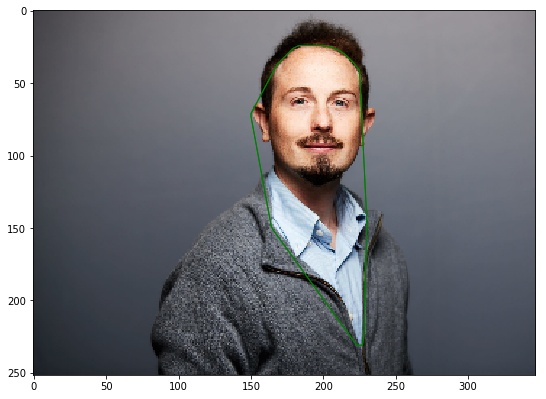

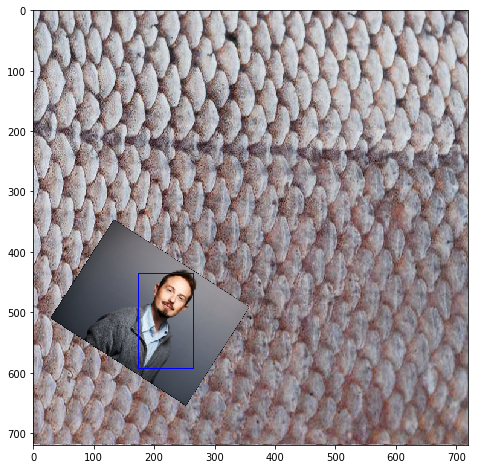

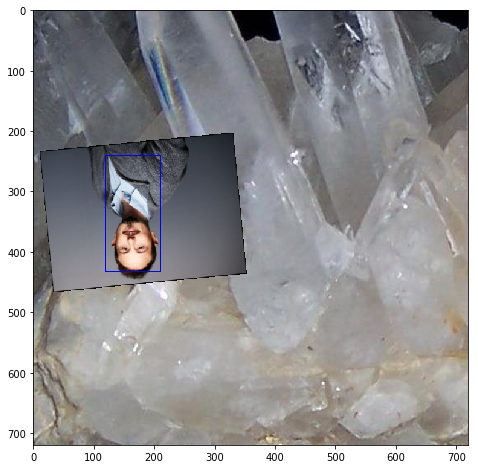

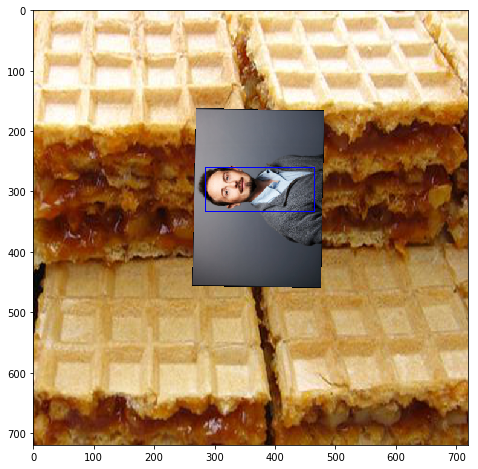

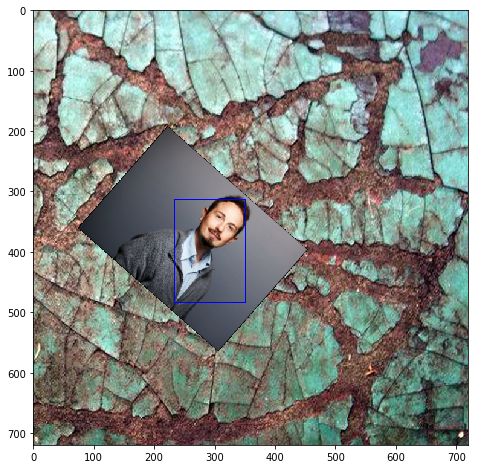

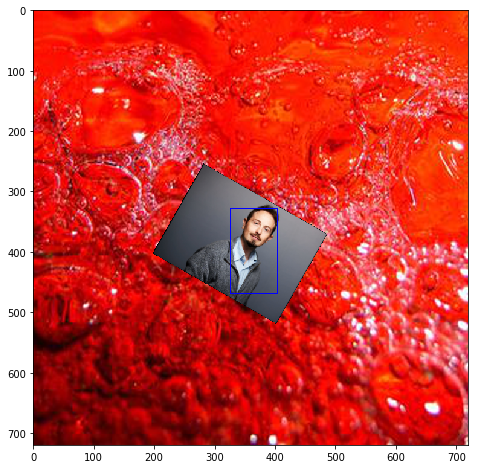

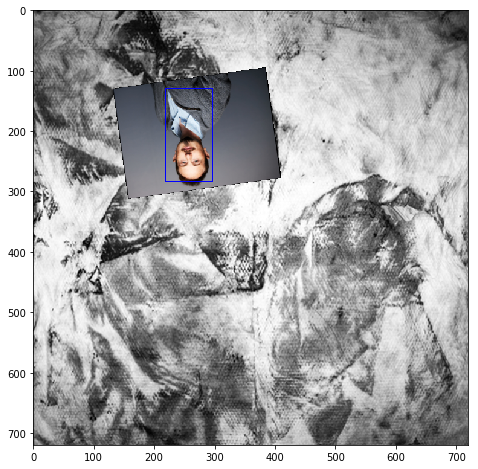

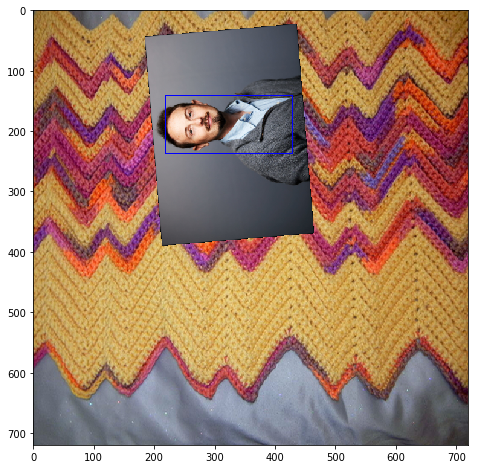

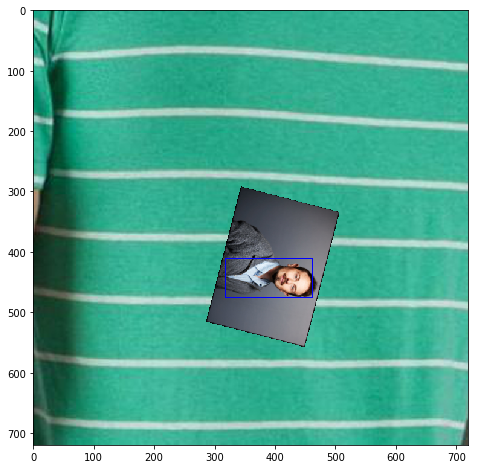

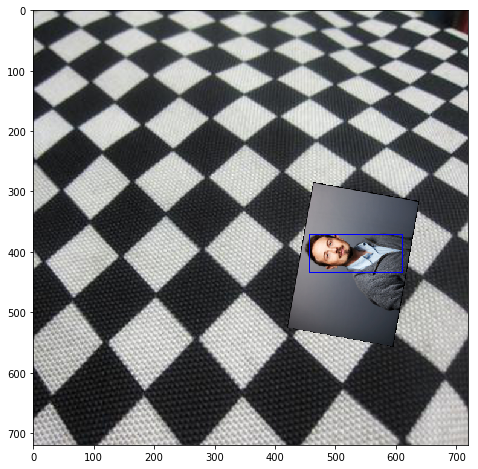

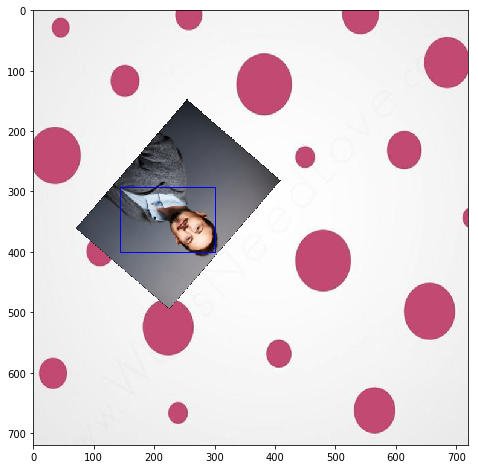

In [115]:
generated_scenes=GenerateImages(ImagePath,num_to_generate,720,720,backgrounds_pck_fn)

In [ ]:
plt.imshow(generated_scenes['scenes'][0]['scene1'])